<a href="https://colab.research.google.com/github/seungjjae/SELF_STUDY_MLDL/blob/main/%ED%98%BC%EA%B3%B5%EB%A8%B8_chapter9_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


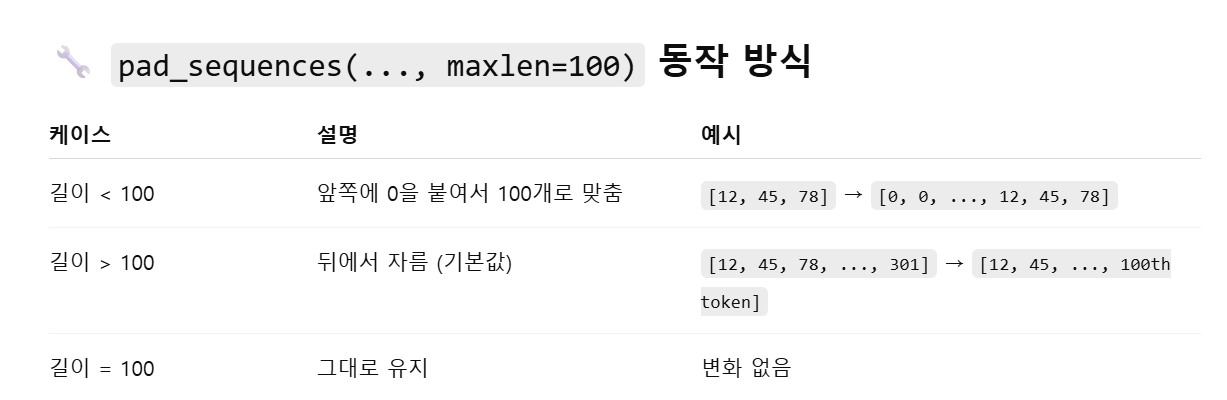

- 위 방식으로 패딩(늘리기) or 절단을 하여 모델에서의 토큰수를 모두 통일
- 또한 현재 데이터셋에서 자주 사용되는 단어 500개만을 사용하여 모델을 구성
=> 500개 외의 단어는 모델에 의미없는 단어로 간주
- sigmoid를 사용하여 마지막에 긍정/부정으로 분류 (지도학습을 통한 학습)

# LSTM과 GRU 셀

In [3]:
import tensorflow as tf

tf.keras.utils.set_random_seed(42)

## LSTM 신경망 훈련하기

In [4]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500)

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [6]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,809 (34.41 KB)

 Trainable params: 8,809 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.5110 - loss: 0.6929 - val_accuracy: 0.5864 - val_loss: 0.6911
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - accuracy: 0.5784 - loss: 0.6907 - val_accuracy: 0.6258 - val_loss: 0.6874
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.6217 - loss: 0.6858 - val_accuracy: 0.6562 - val_loss: 0.6765
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.6681 - loss: 0.6682 - val_accuracy: 0.7096 - val_loss: 0.6177
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.7180 - loss: 0.6006 - val_accuracy: 0.7248 - val_loss: 0.5760
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.7282 - loss: 0.5690 - val_accuracy: 0.7404 - val_loss: 0.5555
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 52ms/step - accuracy: 0.7481 - loss: 0.5465 - val_accuracy: 0.7450 - val_loss: 0.5383
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.7600 - loss: 0

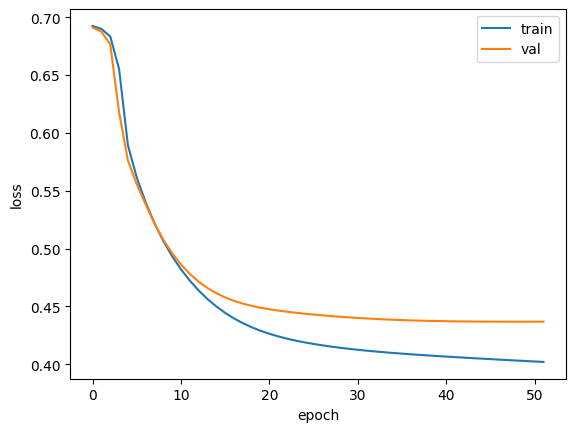

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 순환 층에 드롭아웃 적용하기

In [9]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.5145 - loss: 0.6930 - val_accuracy: 0.5716 - val_loss: 0.6922
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.5619 - loss: 0.6920 - val_accuracy: 0.6068 - val_loss: 0.6908
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.6025 - loss: 0.6902 - val_accuracy: 0.6288 - val_loss: 0.6879
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.6257 - loss: 0.6865 - val_accuracy: 0.6490 - val_loss: 0.6809
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.6458 - loss: 0.6773 - val_accuracy: 0.6560 - val_loss: 0.6494
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.6848 - loss: 0.6394 - val_accuracy: 0.7270 - val_loss: 0.5991
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.7198 - loss: 0.5997 - val_accuracy: 0.7404 - val_loss: 0.5803
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.7326 - loss: 0

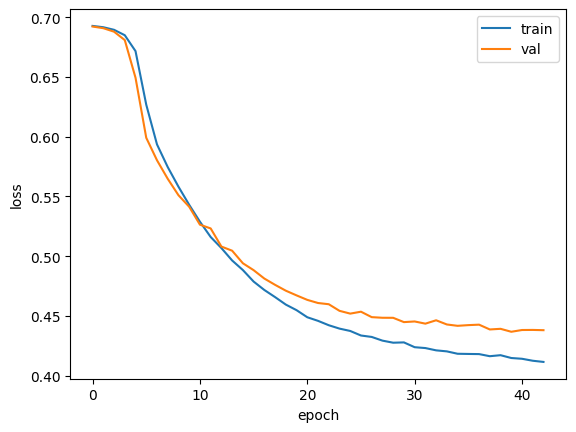

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 2개의 층을 연결하기

In [12]:
model3 = keras.Sequential()

model3.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 8)         │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,353 (36.54 KB)

 Trainable params: 9,353 (36.54 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model3.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 91ms/step - accuracy: 0.5235 - loss: 0.6927 - val_accuracy: 0.5964 - val_loss: 0.6907
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.5854 - loss: 0.6888 - val_accuracy: 0.6470 - val_loss: 0.6764
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - accuracy: 0.6495 - loss: 0.6604 - val_accuracy: 0.7104 - val_loss: 0.5774
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 86ms/step - accuracy: 0.7134 - loss: 0.5717 - val_accuracy: 0.7346 - val_loss: 0.5318
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 86ms/step - accuracy: 0.7405 - loss: 0.5346 - val_accuracy: 0.7580 - val_loss: 0.5051
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.7571 - loss: 0.5090 - val_accuracy: 0.7616 - val_loss: 0.4972
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 86ms/step - accuracy: 0.7712 - loss: 0.4930 - val_accuracy: 0.7654 - val_loss: 0.4921
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - accuracy: 0.7732 - loss: 0

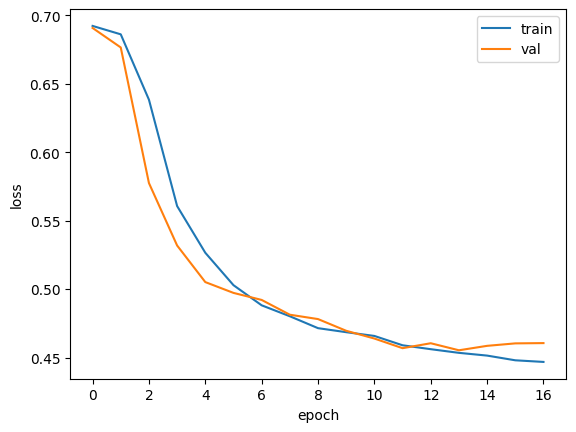

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## GRU 신경망 훈련하기

In [15]:
model4 = keras.Sequential()

model4.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 8)              │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,633 (33.72 KB)

 Trainable params: 8,633 (33.72 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model4.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.5052 - loss: 0.6931 - val_accuracy: 0.5206 - val_loss: 0.6928
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 65ms/step - accuracy: 0.5532 - loss: 0.6925 - val_accuracy: 0.5616 - val_loss: 0.6921
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.5831 - loss: 0.6917 - val_accuracy: 0.5714 - val_loss: 0.6911
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.5901 - loss: 0.6903 - val_accuracy: 0.5844 - val_loss: 0.6893
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.6033 - loss: 0.6882 - val_accuracy: 0.5938 - val_loss: 0.6866
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.6136 - loss: 0.6849 - val_accuracy: 0.6036 - val_loss: 0.6822
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.6197 - loss: 0.6796 - val_accuracy: 0.6120 - val_loss: 0.6752
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.6300 - loss: 0

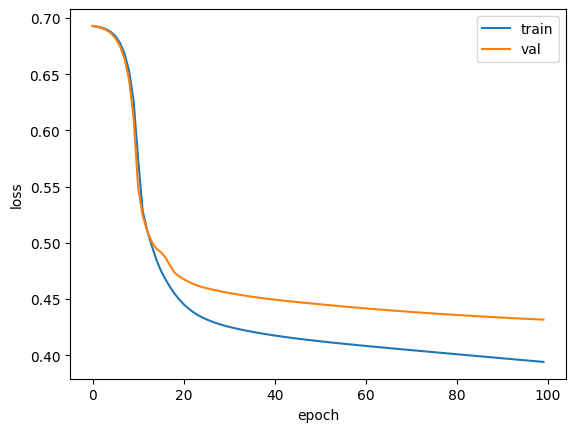

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

# 마무리

In [18]:
test_seq = pad_sequences(test_input, maxlen=100)

rnn_model = keras.models.load_model('best-2rnn-model.keras')

rnn_model.evaluate(test_seq, test_target)

782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.7877 - loss: 0.4545


[0.4543180465698242, 0.7878400087356567]